## 準備

### サンプルデータのダウンロード
著者サイトで公開されているデータを使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

In [1]:
import requests
import zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, chi2
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
%precision 3

'%.3f'

In [3]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 種子数データ

In [4]:
# 著者サイトからdata3a.csvをダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/poisson/data3a.csv')
with open ('data3a.csv', 'wb') as f:
    f.write(response.content)
    f.close()

In [5]:
# サンプルデータをロード
data = pd.read_csv('data3a.csv')

In [6]:
# 先頭5行の表示
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


## 5.2 尤度比検定の例題：逸脱度の差を調べる

In [7]:
# 一定モデルを作る
const_model_results = smf.poisson('y ~ 1', data=data).fit()

const_model_results.summary()

Optimization terminated successfully.
         Current function value: 2.376432
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                   0.000
Time:                        20:08:31   Log-Likelihood:                -237.64
converged:                       True   LL-Null:                       -237.64
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0580      0.036     57.586      0.000         1.988     2.128
==============================================================================
"""

In [8]:
# 一定モデルの逸脱度
const_model_deviance = (-2) * const_model_results.llf
const_model_deviance

475.286

In [9]:
# xモデルを作る
x_model_results = smf.poisson('y ~ x', data=data).fit()

x_model_results.summary()

Optimization terminated successfully.
         Current function value: 2.353863
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                0.009497
Time:                        20:08:34   Log-Likelihood:                -235.39
converged:                       True   LL-Null:                       -237.64
                                        LLR p-value:                   0.03362
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

In [10]:
# xモデルの逸脱度
x_model_deviance = (-2) * x_model_results.llf
x_model_deviance

470.773

In [11]:
# 逸脱度の差Dを計算
d = -2 * (const_model_results.llf - x_model_results.llf)
d

4.514

### 5.4 帰無仮説を棄却するための有意水準

In [12]:
def pb(data, n):
    # パラメトリックブートストラップ法(PB法)によるP値の計算
    const_model_data = data.copy()
    pb_d = []

    # n個のデータセットからn個の逸脱度の差を計算
    for i in range(n):
        # 一定モデルから目的変数100個生成
        const_model_data['y'] = np.random.poisson(const_model_results.params['Intercept'], len(data))

        # 逸脱度の差を計算
        const_model_llf = smf.poisson('y ~ 1', data=const_model_data).fit(disp=0).llf
        x_model_llf = smf.poisson('y ~ x', data=const_model_data).fit(disp=0).llf
        pb_d.append(-2 * (const_model_llf - x_model_llf))
        
    return pb_d
    
# 1000個のデータセットで計算
pb_d = pb(data, 1000)

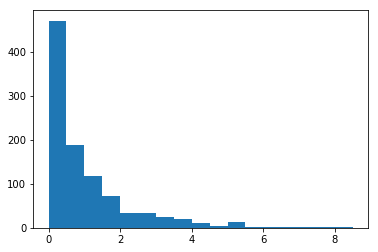

In [13]:
# ヒストグラムで分布を表示
plt.hist(pb_d, bins=np.arange(0, math.ceil(max(pb_d)), 0.5))
plt.show()

In [14]:
# P値の計算
p = (pb_d > d).sum() / len(pb_d)
p

0.031

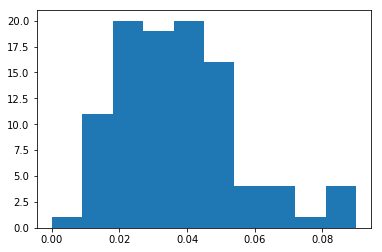

In [15]:
# 100個くらいのデータセットだと、P値もばらつきが大きい
p_100 = []

for i in range(100):
    pb_d = pb(data, 100)
    p_100.append((pb_d > d).sum() / len(pb_d))

plt.hist(p_100)
plt.show()

In [16]:
# 0.05以上をカウント
[p >= 0.05 for p in p_100].count(True)

29

In [17]:
# カイ二乗分布による近似

# エラーになります
sm.stats.anova_lm(const_model_results, x_model_results, test='Chisq')

AttributeError: 'PoissonResults' object has no attribute 'ssr'

In [18]:
# from scipy.stats import chi2
p = chi2.sf(x=d, df=1)
p

0.034